<a href="https://colab.research.google.com/github/CarlTeapot/ML_assignment4/blob/main/ModelExperiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [4]:
od.download("https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: matearevadze
Your Kaggle Key: ··········


100%|██████████| 285M/285M [00:00<00:00, 841MB/s]



Extracting archive ./challenges-in-representation-learning-facial-expression-recognition-challenge/challenges-in-representation-learning-facial-expression-recognition-challenge.zip to ./challenges-in-representation-learning-facial-expression-recognition-challenge


In [5]:
train_data = pd.read_csv("/content/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv")

In [6]:
def convertToTensors(df):
    image_matrix = np.vstack(df['pixels'].str.split().apply(lambda x: np.array(x, dtype='float32')))
    image_tensor = image_matrix.reshape(-1, 1, 48, 48)
    label_tensor = df['emotion'].values.astype('int64')
    return torch.tensor(image_tensor), torch.tensor(label_tensor)

In [7]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear = nn.Linear(128 * 6 * 6, 128)
        self.output = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pooling(self.relu(self.conv1(x)))
        x = self.pooling(self.relu(self.conv2(x)))
        x = self.pooling(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x

model = Net().to(device)


In [8]:
from torchsummary import summary
summary(model, input_size = (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
              ReLU-8          [-1, 128, 12, 12]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 128]         589,952
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 7]             903
Total params: 683,527
Trainable params:

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

x,y = convertToTensors(train_data)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=BATCH_SIZE)

In [11]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

EPOCHS = 10

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    # TRAINING
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        optimizer.step()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc

    # VALIDATION
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    # STATS
    num_train = len(train_loader.dataset)
    num_val = len(val_loader.dataset)

    avg_loss_train = total_loss_train / len(train_loader)
    avg_loss_val = total_loss_val / len(val_loader)
    acc_train = 100 * total_acc_train / num_train
    acc_val = 100 * total_acc_val / num_val

    total_loss_train_plot.append(round(avg_loss_train, 4))
    total_loss_validation_plot.append(round(avg_loss_val, 4))
    total_acc_train_plot.append(round(acc_train, 4))
    total_acc_validation_plot.append(round(acc_val, 4))

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {avg_loss_train:.4f} | Train Acc: {acc_train:.2f}%")
    print(f"  Val   Loss: {avg_loss_val:.4f} | Val   Acc: {acc_val:.2f}%")
    print("="*30)


Epoch 1/10
  Train Loss: 1.7089 | Train Acc: 34.26%
  Val   Loss: 1.5312 | Val   Acc: 42.35%
Epoch 2/10
  Train Loss: 1.4409 | Train Acc: 45.30%
  Val   Loss: 1.3767 | Val   Acc: 48.52%
Epoch 3/10
  Train Loss: 1.2985 | Train Acc: 51.25%
  Val   Loss: 1.3207 | Val   Acc: 50.05%
Epoch 4/10
  Train Loss: 1.1727 | Train Acc: 56.15%
  Val   Loss: 1.3305 | Val   Acc: 50.47%
Epoch 5/10
  Train Loss: 1.0471 | Train Acc: 61.27%
  Val   Loss: 1.2434 | Val   Acc: 53.71%
Epoch 6/10
  Train Loss: 0.9167 | Train Acc: 66.57%
  Val   Loss: 1.2785 | Val   Acc: 52.66%
Epoch 7/10
  Train Loss: 0.7785 | Train Acc: 71.87%
  Val   Loss: 1.3578 | Val   Acc: 53.33%
Epoch 8/10
  Train Loss: 0.6421 | Train Acc: 77.14%
  Val   Loss: 1.4006 | Val   Acc: 53.88%
Epoch 9/10
  Train Loss: 0.5136 | Train Acc: 82.05%
  Val   Loss: 1.5498 | Val   Acc: 53.43%
Epoch 10/10
  Train Loss: 0.3996 | Train Acc: 86.40%
  Val   Loss: 1.6304 | Val   Acc: 54.30%


In [12]:
model.eval()  # Set to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [13]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 54.16%


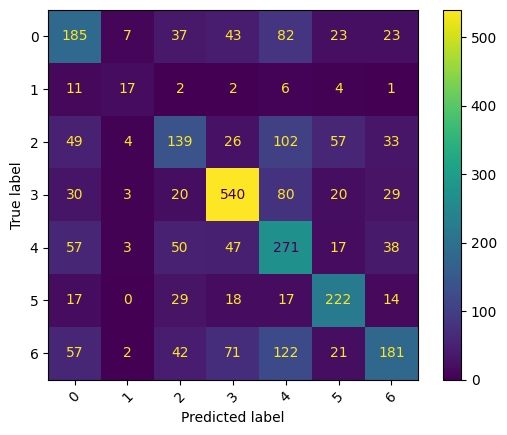

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)

In [17]:

with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += acc

        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test / len(test_loader)) * 100, 4)} and Loss is {round(total_loss_test / len(test_loader), 4)}")


Accuracy Score is: 863.8889 and Loss is 1.7472


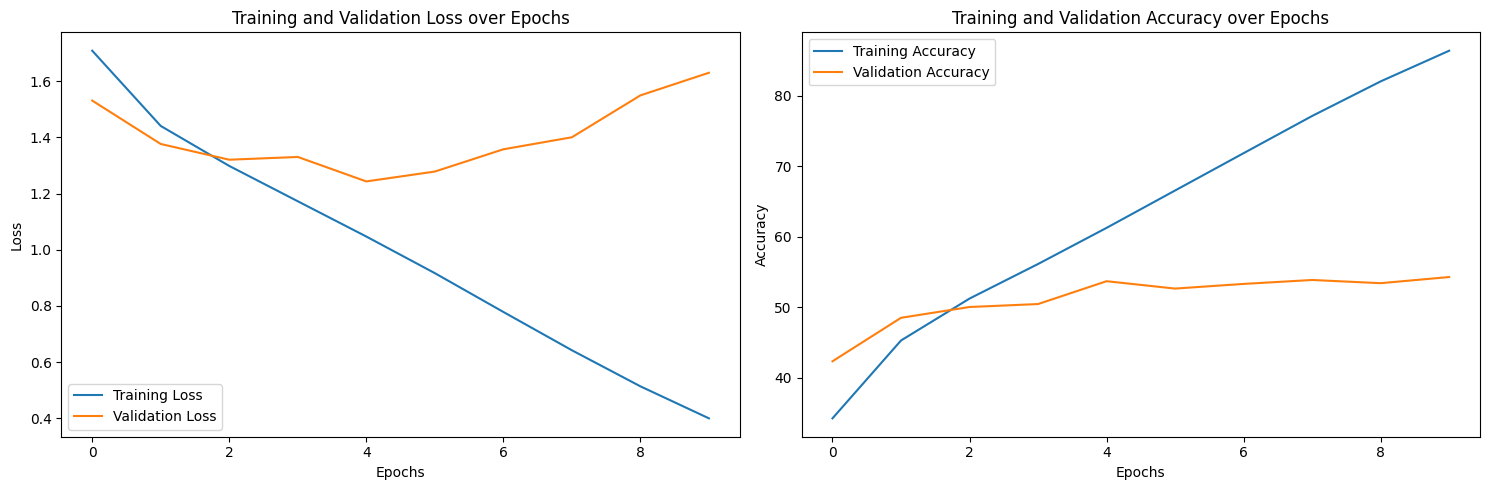

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
import wandb

wandb.init(project="your_project_name", name="experiment_name")

config = {
    "epochs": 10,
    "batch_size": BATCH_SIZE,
    "learning_rate": LR
}
wandb.init(project="your_project_name", config=config)

artifact = wandb.Artifact('model-name', type='model')
artifact.add_file('model.pth')
wandb.log_artifact(artifact)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: